Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [250]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 12})

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [2]:
#model_name = 'mtm_2spring_tendon'
model_name = 'mtm'

model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [5]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

# define paralelogram coordinate relation
qd2 = q2
qd3 = -q2 + q3
qd4 = 0.6697*q2 - 0.6697*q3 + q4


qmd1 = q1
qmd2 = qd2
qmd30 = qd3
qmd31 = qd3 + qd2 
qmd32 = -qd3
qmd33 = q3
qmd4 = qd4
qmd5 = q5
qmd6 = q6
qmd7 = q7

# q31 = q3 + q2 
# q32 = -q3

l_base2pitch = 215.4 * 0.001
l_arm = 279.4 * 0.001
l_back2front = 100 * 0.001
l_forearm = 364.5 * 0.001
h =105.6 * 0.001

L_b = 0
L_1 = 1
L_2 = 2
L_30 = 3
L_31 = 4
L_32 = 5
L_4 = 6
L_5 = 7
L_6 = 8
L_7 = 9

M_4 = 10


dh = [(L_b,  -1,   [L_1, M_4],  0,            0,      0,             0,           False, False, False),
      (L_1,  L_b,  [L_2, L_31], 0,            0,      -l_base2pitch, qmd1,        True,  False, True),
      (L_2,  L_1,  [L_30],      0,            -_pi/2, 0,             qmd2+_pi/2,  True,  False, True),
      (L_30, L_2,  [L_4],       l_arm,        0,      0,             qmd30+_pi/2, True,  False, True),
      (L_31, L_1,  [L_32],      0,            -_pi/2, 0,             qmd31+_pi,   True,  False, True),
      (L_32, L_31, [],          l_back2front, 0,      0,             qmd32-_pi/2, True,  False, True),
      (L_4,  L_30, [L_5],       l_forearm,    -_pi/2, 0.151,         qmd4,        True,  False, True),
      (L_5,  L_4,  [L_6],       0,            _pi/2,  0,             qmd5,        True,  False, True),
      (L_6,  L_5,  [L_7],       0,            -_pi/2, 0,             qmd6+_pi/2,  True,  False, True),
      (L_7,  L_6,  [],          0,            -_pi/2, 0,             qmd7+_pi,    True,  False, True),
      (M_4,  L_b,  [],          0,            0,      0,             q4,          False, True, True)]

q = qmd5
r_s = 0.0075
h_s = 0.1035
l_r = 0.0613
q_o = 23.0/180.0*_pi
l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
d_l = l - l_r
r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
tau_s = r_f * d_l # * 27.86
#springs = [tau_s, -qmd4]
springs = [tau_s]

friction_type = ['Coulomb', 'viscous', 'offset']
print(model_name)


print(friction_type)
robot_def = RobotDef(dh,
                     springs=springs,
                     dh_convention='mdh',
                     friction_type=friction_type)

mtm
['Coulomb', 'viscous', 'offset']


In [6]:
robot_def.dq_for_frame

In [7]:
robot_def.coordinates_joint_type

['R', 'R', 'R', 'R', 'R', 'R', 'R']

In [8]:
robot_def.bary_params

## Create kinematics chain

In [9]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
CPU times: user 55min 31s, sys: 8.34 s, total: 55min 39s
Wall time: 55min 31s


In [112]:
angle = [0, 0.5, 0, 0, 0, 0, 0]
geom.draw_geom(angle)

## Create dynamics

In [11]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/10
Calculating the link kinetic energy of 2/10
Calculating the link kinetic energy of 3/10
Calculating the link kinetic energy of 4/10
Calculating the link kinetic energy of 5/10
Calculating the link kinetic energy of 6/10
Calculating the link kinetic energy of 7/10
Calculating the link kinetic energy of 8/10
Calculating the link kinetic energy of 9/10
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
tau of q7
Adding frictions and springs...
Add motor inertia...
Calculating regressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 73
Creating H_b function...
Finished creating robot dynamics
CPU times: user 28min, sys: 7.66 s, total: 28min 7s
Wall time: 27min 58s


In [12]:
robot_def.bary_params

In [13]:
sympy.Matrix(dyn.base_param)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [14]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 73 parameters


---
# 3 - Excitation trajectory optimization

In [117]:
model_name = 'mtm'

Load Data

In [118]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [131]:
#trajectory_name = 'one'
trajectory_name = 'two'

In [132]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.1
fourier_order = 6

cartesian_constraints = []


joint_constraints = [(qmd1,  deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                     (qmd2,  deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                     (qmd30, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                     (qmd4,  deg2rad(-40), deg2rad(195), deg2rad(-360), deg2rad(360)),
                     (qmd5,  deg2rad(-87), deg2rad(180), deg2rad(-360), deg2rad(360)),
                     (qmd6,  deg2rad(-40), deg2rad(38), deg2rad(-360), deg2rad(360)),
                     (qmd7,  deg2rad(-460), deg2rad(450), deg2rad(-720), deg2rad(720)),
                     (qmd31, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]

    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 8
cartesian constraint number: 0
constraint number: 32
frames_constrained: []
Condition number: 71.6916728811
Condition number: 71.6916727154
Condition number: 79.8504984279
Condition number: 78.4805440672
Condition number: 87.0128170834
Condition number: 101.388717456
Condition number: 371.048938703
Condition number: 282.81368471
Condition number: 249.117904707
Condition number: 243.799910571
Condition number: 241.141573213
Condition number: 238.103219596
Condition number: 236.529212636
Condition number: 233.654582149
Condition number: 231.933502177
Condition number: 225.209094211
Condition number: 222.72475041
Condition number: 219.227923674
Condition number: 218.285703617
Condition number: 216.966971693
Condition number: 216.631596376
Condition number: 215.299785729
Condition number: 214.823738007
Condition number: 214.427399062
Condition number: 214.145137186
Condition number: 213.367118572
Condition number: 212.660252276
Condition number: 212.404438077
Con

In [143]:
robot_model.coordinates

In [144]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [145]:
traj_optimizer.calc_frame_traj()

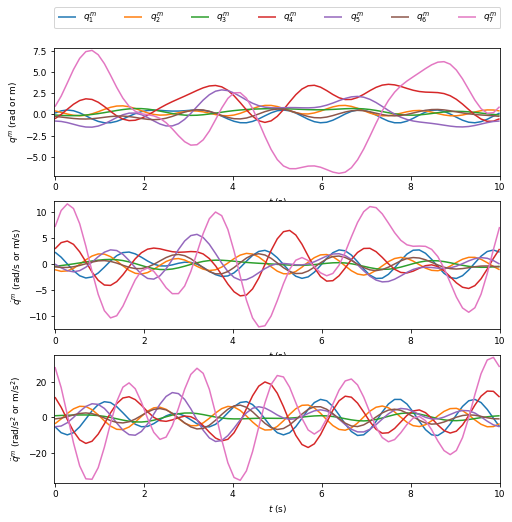

In [251]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

# traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [147]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

In [148]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,-0.1725,0.0964,-0.0593,-0.3716,0.3209,0.8143,1.5327,0.0134,0.2114,-0.1592,-0.5427,0.6316,-1.5354
q2,0.32,0.0004,0.2391,-0.0001,-0.3474,0.1398,-1.0951,0.0784,-0.0877,0.1819,0.1229,0.1152,-1.1986
q3,0.3039,-0.0235,0.189,-0.1333,-0.6143,-0.0306,0.2063,0.1428,-0.044,0.2399,0.1305,0.0597,-0.0245
q4,1.5334,-0.5093,-0.3866,0.2838,2.6524,-0.7448,1.6646,0.3534,1.0323,-0.8533,1.3964,0.0958,2.0227
q5,0.153,-0.0557,0.0286,0.9777,-1.0311,-0.9516,1.0576,0.9374,0.1272,-0.9501,0.9764,-0.6639,-1.2108
q6,-0.0318,-0.1342,-0.2487,-0.1645,0.1076,-0.0892,0.0025,0.0749,0.0485,0.0461,0.0633,0.9008,-1.0691
q7,0.1182,0.248,-2.3547,4.5869,0.8865,2.2845,1.5443,-2.8512,-0.1037,2.9538,2.6772,-0.4461,5.0927


---
# Data processing

In [149]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor
import copy

## Load data

### Load robot model

In [150]:
# Names as Arguments
model_name = 'mtm'
#model_name = 'mtm_2spring_tendon'
training_trajectory_name = 'one'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                               training_trajectory_name)
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.1


### Load traning data set

In [151]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)
# remove the cable part of the joint 4
# from high to low
p = np.array([0.0004877, -0.0037149, 0.0067497, 0.008519, -0.0201475, -0.025265, 0.048095, 0.00255])
#p = p[::-1]

qm4_raw_train = 0.6697*q_raw_train[:,1] - 0.6697*q_raw_train[:,2] + q_raw_train[:,3]
tau_cable4_train = p[0]*qm4_raw_train**7 + p[1]*qm4_raw_train**6 + p[2]*qm4_raw_train**5\
+ p[3]*qm4_raw_train**4 + p[4]*qm4_raw_train**3 + p[5]*qm4_raw_train**2\
+ p[6]*qm4_raw_train + p[7]
tau_raw_train[:,1] -= 0.6697*tau_cable4_train
tau_raw_train[:,2] += 0.6697*tau_cable4_train
tau_raw_train[:,3] -= tau_cable4_train

(<type 'numpy.ndarray'>, (5999, 21))


In [152]:
np.array([[1.0, 0, 0], [-1.0, 1.0, 0], [0.6697, -0.6697, 1.0]]).transpose()

array([[ 1.    , -1.    ,  0.6697],
       [ 0.    ,  1.    , -0.6697],
       [ 0.    ,  0.    ,  1.    ]])

### Training trajectory

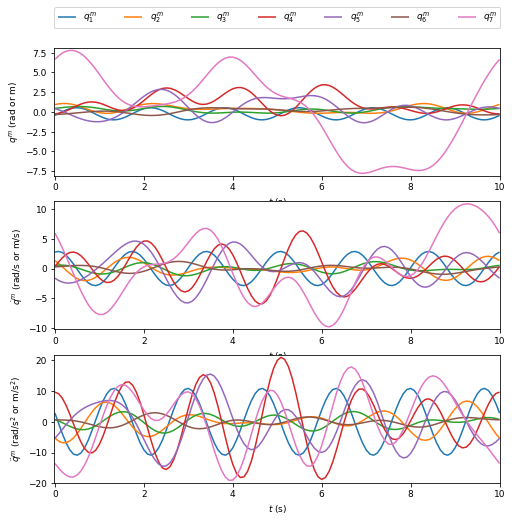

In [252]:
from trajectory_optimization import FourierTraj
fourier_traj_train = FourierTraj(dof, fourier_order, base_freq, sample_num_per_period=20)
traj_plotter_train = TrajPlotter(fourier_traj_train, coordinates=robot_model.coordinates)
traj_plotter_train.plot_desired_traj(traj_optimizer_result)

### Load test data set

In [154]:
test_trajectory_name = 'two'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                trajectory_sampling_rate)
# remove the cable part of the joint 4
# from high to low
p = np.array([0.0004877, -0.0037149, 0.0067497, 0.008519, -0.0201475, -0.025265, 0.048095, 0.00255])
# p = p[::-1]

qm4_raw_test = 0.6697*q_raw_test[:,1] - 0.6697*q_raw_test[:,2] + q_raw_test[:,3]
tau_cable4_test = p[0]*qm4_raw_test**7 + p[1]*qm4_raw_test**6 + p[2]*qm4_raw_test**5\
+ p[3]*qm4_raw_test**4 + p[4]*qm4_raw_test**3 + p[5]*qm4_raw_test**2\
+ p[6]*qm4_raw_test + p[7]
tau_raw_test[:,1] -= 0.6697*tau_cable4_test
tau_raw_test[:,2] += 0.6697*tau_cable4_test
tau_raw_test[:,3] -= tau_cable4_test

plt.plot(qm4_raw_test, tau_cable4_test)

(<type 'numpy.ndarray'>, (5999, 21))


## Calculate filter cut-off frequency

In [155]:
# times of the highest frequency in the Fourier series

fc_mult = [3]
#fc_mult = [5, 5, 5, 3, 4, 4, 4]

#fc_mult = 4
fc = np.array(fc_mult)*base_freq* fourier_order 

print("Cut frequency: {}".format(fc))

Cut frequency: [1.8]


## Differentiation and filtering

### Traning data

q_raw shape: (5999, 7)
plot shape: 470


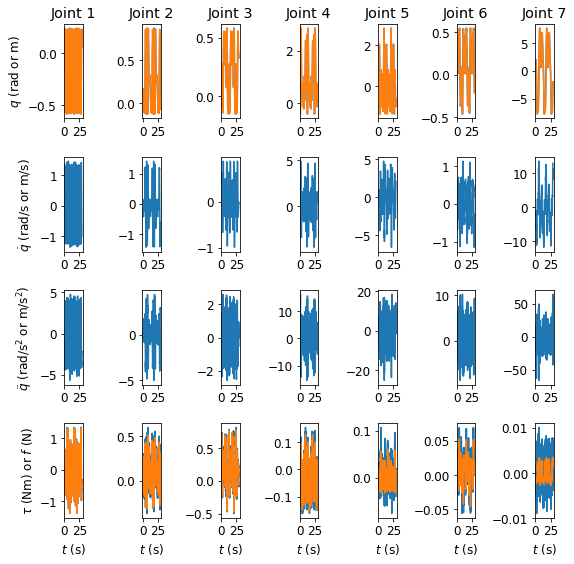

In [253]:
cut_num = 200
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc, cut_num)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

q_raw shape: (5999, 7)
plot shape: 470


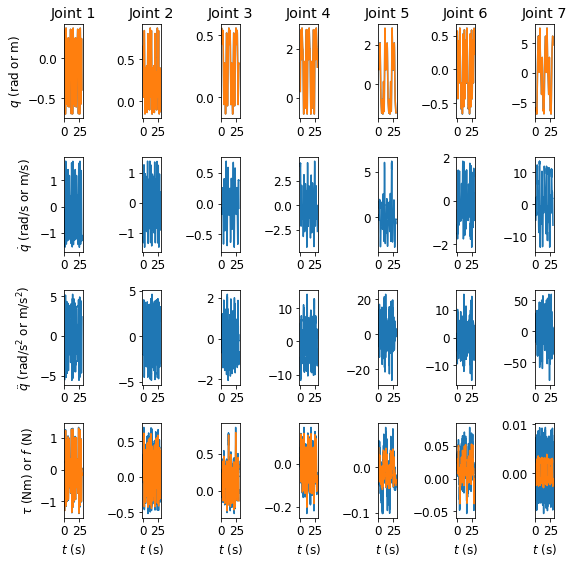

In [254]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc, cut_num)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [158]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [159]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [160]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [161]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*L9xy,5.747089788324422e-05
1.0*L9yz,3.612507875676253e-06
1.0*L9xz,5.0194250956633445e-05
1.0*L8xy,0.00013116035212497497
1.0*L8yz,0.00024135878100094762
1.0*L8xz,-0.0001927998447133197
1.0*L7xy,-0.00014592111809612167
1.0*L9zz,8.373941306227036e-05
-1.0*L9xx + 1.0*L9yy,4.757709527834081e-05
1.0*L7yz,-0.0007482797704601004


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [162]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]

# add cable torque back
qm4_f_train = 0.6697*q_f_train[:,1] - 0.6697*q_f_train[:,2] + q_f_train[:,3]
tau_cable4_f_train = p[0]*qm4_f_train**7 + p[1]*qm4_f_train**6 + p[2]*qm4_f_train**5\
+ p[3]*qm4_f_train**4 + p[4]*qm4_f_train**3 + p[5]*qm4_f_train**2\
+ p[6]*qm4_f_train + p[7]
tau_f_with_cable_train = copy.deepcopy(tau_f_train);
tau_f_with_cable_train[:,1] = tau_f_train[:,1] + 0.6697*tau_cable4_f_train
tau_f_with_cable_train[:,2] = tau_f_train[:,2] - 0.6697*tau_cable4_f_train
tau_f_with_cable_train[:,3] = tau_f_train[:,3] + tau_cable4_f_train
tau_p_with_cable_train = copy.deepcopy(tau_p_train);
tau_p_with_cable_train[:,1] = tau_p_train[:,1] + 0.6697*tau_cable4_f_train
tau_p_with_cable_train[:,2] = tau_p_train[:,2] - 0.6697*tau_cable4_f_train
tau_p_with_cable_train[:,3] = tau_p_train[:,3] + tau_cable4_f_train

### Evaluate regression

In [163]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.00013127972875237094
standard deviation of xb using OLS:
[3.43415884e-06 2.03135440e-06 2.06639367e-06 1.47752322e-05
 1.58194863e-05 1.92175583e-05 1.84062507e-05 5.33004649e-06
 6.88515574e-06 2.16637027e-05 7.40531728e-06 7.30401918e-06
 1.54214959e-05 2.46146670e-05 4.59260984e-05 2.76925780e-05
 4.87016610e-05 2.38056131e-05 1.14528642e-04 2.97011644e-05
 3.91292312e-05 3.35879542e-05 5.17694651e-05 3.74098462e-05
 3.70651650e-05 1.64054618e-03 7.08905068e-04 5.03708525e-03
 1.51120535e-04 3.37226242e-05 4.71601964e-05 2.23739502e-04
 6.25818472e-04 5.82634390e-04 1.13604442e-04 1.25554051e-04
 4.98141457e-04 2.52327972e-04 1.59262510e-04 1.02302718e-03
 1.58410867e-04 5.76290965e-04 1.68200092e-03 1.04570271e-03
 3.87499275e-04 1.14253793e-04 4.71904863e-05 6.34860635e-04
 5.04861956e-04 4.20807279e-05 1.54188535e-04 4.36294048e-04
 8.18463445e-04 1.96028288e-04 4.22946616e-03 1.23831072e-03
 1.54192447e-04 1.68819918e-04 2.08899112e-04 1

### Plot measured torque and predicted torque

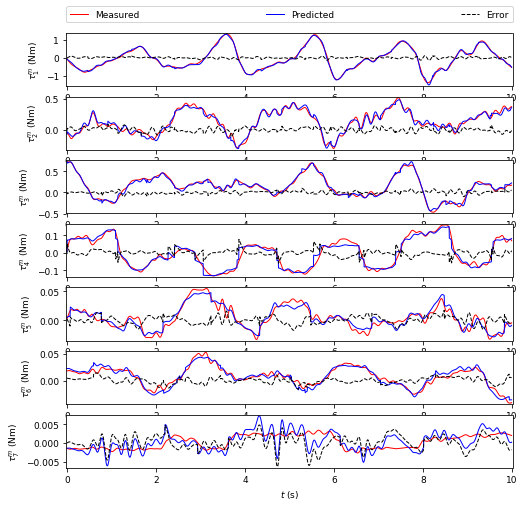

In [255]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_with_cable_train[:plot_data_num, :],
                   tau_p_with_cable_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [176]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

In [177]:
tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

    # add cable torque back
qm4_f_test = 0.6697*q_f_test[:,1] - 0.6697*q_f_test[:,2] + q_f_test[:,3]
tau_cable4_f_test = p[0]*qm4_f_test**7 + p[1]*qm4_f_test**6 + p[2]*qm4_f_test**5\
+ p[3]*qm4_f_test**4 + p[4]*qm4_f_test**3 + p[5]*qm4_f_test**2\
+ p[6]*qm4_f_test + p[7]
tau_f_with_cable_test = copy.deepcopy(tau_f_test);
tau_f_with_cable_test[:,1] = tau_f_test[:,1] + 0.6697*tau_cable4_f_test
tau_f_with_cable_test[:,2] = tau_f_test[:,2] - 0.6697*tau_cable4_f_test
tau_f_with_cable_test[:,3] = tau_f_test[:,3] + tau_cable4_f_test
tau_p_with_cable_test = copy.deepcopy(tau_p_test);
tau_p_with_cable_test[:,1] = tau_p_test[:,1] + 0.6697*tau_cable4_f_test
tau_p_with_cable_test[:,2] = tau_p_test[:,2] - 0.6697*tau_cable4_f_test
tau_p_with_cable_test[:,3] = tau_p_test[:,3] + tau_cable4_f_test

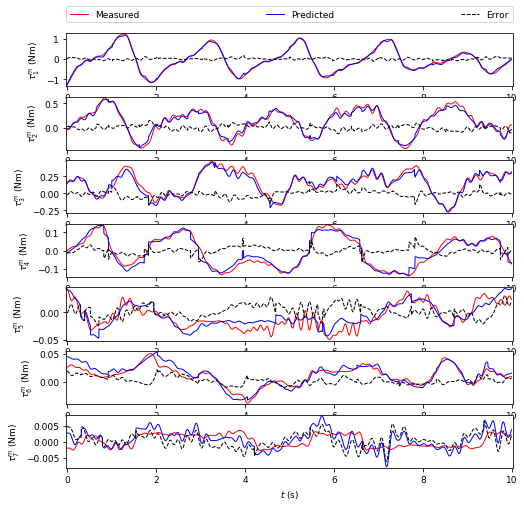

In [256]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Weighted Least Square (WLS)

### Training data set

In [165]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)

In [166]:
W_b_train.shape, tau_s_train.shape

In [167]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [168]:
weights.shape

In [169]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [170]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [171]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [172]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]
    
tau_p_wls_with_cable_train = copy.deepcopy(tau_p_wls_train);
tau_p_wls_with_cable_train[:,1] = tau_p_wls_train[:,1] + 0.6697*tau_cable4_f_train
tau_p_wls_with_cable_train[:,2] = tau_p_wls_train[:,2] - 0.6697*tau_cable4_f_train
tau_p_wls_with_cable_train[:,3] = tau_p_wls_train[:,3] + tau_cable4_f_train

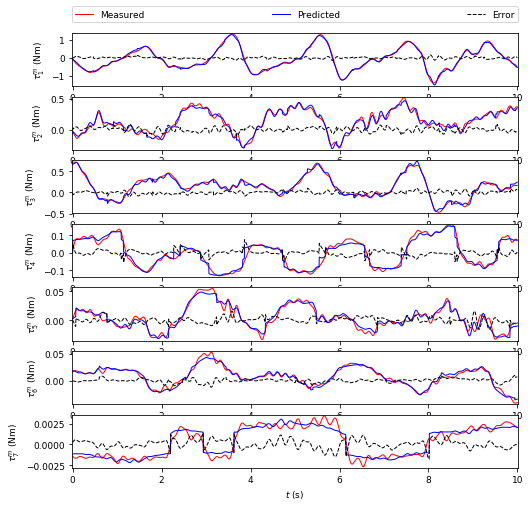

In [257]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_with_cable_train[:plot_data_num, :],
                   tau_p_wls_with_cable_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type, 
                   robot_model.coordinates)

In [174]:
np.linalg.norm(tau_f_with_cable_train[:plot_data_num, :] - tau_p_wls_with_cable_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_with_cable_train[:plot_data_num, :], axis=0)

array([0.07948511, 0.15632085, 0.11793423, 0.18555673, 0.24221743,
       0.18254992, 0.28003719])

### Test data set

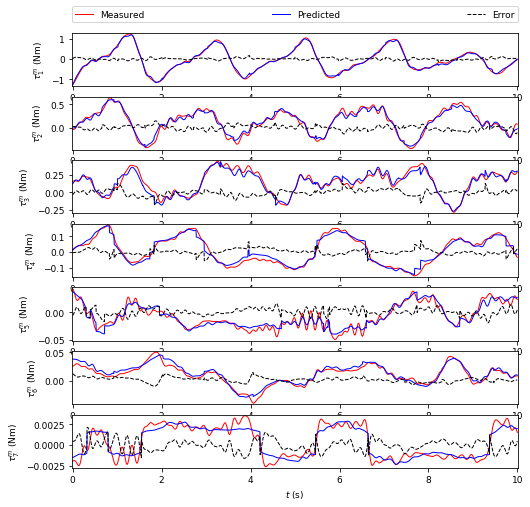

In [258]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

# add cable torque back
# qm4_f_test = 0.6697*q_f_test[:,1] - 0.6697*q_f_test[:,2] + q_f_test[:,3]
# tau_cable4_f_test = p[0]*qm4_f_test**7 + p[1]*qm4_f_test**6 + p[2]*qm4_f_test**5\
# + p[3]*qm4_f_test**4 + p[4]*qm4_f_test**3 + p[5]*qm4_f_test**2\
# + p[6]*qm4_f_test + p[7]
# tau_f_with_cable_test = copy.deepcopy(tau_f_test);
# tau_f_with_cable_test[:,1] = tau_f_test[:,1] + 0.6697*tau_cable4_f_test
# tau_f_with_cable_test[:,2] = tau_f_test[:,2] - 0.6697*tau_cable4_f_test
# tau_f_with_cable_test[:,3] = tau_f_test[:,3] + tau_cable4_f_test
tau_p_wls_with_cable_test = copy.deepcopy(tau_p_wls_test);
tau_p_wls_with_cable_test[:,1] = tau_p_wls_test[:,1] + 0.6697*tau_cable4_f_test
tau_p_wls_with_cable_test[:,2] = tau_p_wls_test[:,2] - 0.6697*tau_cable4_f_test
tau_p_wls_with_cable_test[:,3] = tau_p_wls_test[:,3] + tau_cable4_f_test

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_with_cable_test[:plot_data_num, :],
                   tau_p_wls_with_cable_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [180]:
np.linalg.norm(tau_f_with_cable_test[:plot_data_num, :] - tau_p_wls_with_cable_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.08178377, 0.16308936, 0.19056985, 0.2090203 , 0.26304677,
       0.23482655, 0.33959325])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [181]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [210]:
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_train.shape[0]/weight.shape[0])
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

In [211]:
weight

array([2.70936727, 0.83146351, 1.25359933, 0.27772567, 0.09333127,
       0.09894924, 0.00623326])

In [212]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [226]:
sdp_constraints = [(2, 20, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.2, 0.2, 0.2), #1
                  (1, 15, -0.1, 0.15, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.3), #2
                  (0.5, 5, -0.0, 0.3, -0.03, 0.03, -0.03, 0.03, 0.2, 0.2, 0.2), # 3
                  (1, 10, -0.1, 0.1, -0.05, 0.05, -0.1, 0.1, 0.2, 0.2, 0.3), # 3'
                  (0.05, 2, 0.05, 0.2, -0.02, 0.02, 0.02, 0.1, 0.2, 0.2, 0.2), # 3''
                  (0.05, 2, -0.03, 0.03, -0.00, 0.12, -0.15, 0.0, 0.2, 0.2, 0.2), # 4
                  (0.05, 1, -0.02, 0.02, -0.1, 0.00, -0.1, 0.00, 0.2, 0.2, 0.2), # 5
                  (0.05, 0.5, -0.02, 0.02, 0, 0.1, -0.1, 0.00, 0.2, 0.2, 0.2), # 6
                  (0.02, 0.5, -0.01, 0.01, -0.01, 0.01, -0.00, 0.1, 0.2, 0.2, 0.2), #7
                  (0.0, 0, 0.00, 0.00, -0.00, 0.00, 0.000, 0.00, 0.2, 0.2, 0.2)]
spring_constraints = [(250, 300)]

In [227]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints, spring_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve()

Regressor shape: (39193, 122)
Regressand shape: (39193,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1786399, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 20000, normalize = 1, scale = 1.00
Variables n = 123, constraints m = 39520
Cones:	linear vars: 136
	soc vars: 39195, soc blks: 1
	sd vars: 189, sd blks: 9
Setup time: 7.13e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.58e+02  2.33e+00  1.00e+00 -7.37e+04 -9.34e-03  1.20e-11  1.29e-01

  9400| 4.88e-02  6.16e-05  1.45e-02  2.61e-01  2.39e-01  8.48e-13  3.15e+02 
  9500| 4.88e-02  6.12e-05  1.45e-02  2.64e-01  2.42e-01  8.48e-13  3.18e+02 
  9600| 4.88e-02  6.33e-05  1.46e-02  2.67e-01  2.45e-01  8.48e-13  3.20e+02 
  9700| 4.88e-02  6.18e-05  1.47e-02  2.69e-01  2.47e-01  8.48e-13  3.23e+02 
  9800| 4.88e-02  6.34e-05  1.48e-02  2.72e-01  2.50e-01  8.48e-13  3.26e+02 
  9900| 4.88e-02  6.38e-05  1.49e-02  2.75e-01  2.52e-01  8.48e-13  3.29e+02 
 10000| 4.88e-02  6.31e-05  1.49e-02  2.78e-01  2.55e-01  8.48e-13  3.32e+02 
 10100| 4.88e-02  6.50e-05  1.50e-02  2.80e-01  2.57e-01  8.48e-13  3.35e+02 
 10200| 4.88e-02  6.41e-05  1.51e-02  2.83e-01  2.60e-01  8.48e-13  3.38e+02 
 10300| 4.88e-02  6.52e-05  1.52e-02  2.86e-01  2.63e-01  8.48e-13  3.40e+02 
 10400| 4.88e-02  6.52e-05  1.52e-02  2.89e-01  2.65e-01  8.48e-13  3.43e+02 
 10500| 4.88e-02  6.56e-05  1.53e-02  2.92e-01  2.68e-01  8.48e-13  3.46e+02 
 10600| 4.88e-02  6.62e-05  1.54e-02  2.94e-01  2.70e-01  8.48e-

 20000| 4.86e-02  8.53e-05  1.88e-02  5.54e-01  5.15e-01  8.49e-13  6.00e+02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 6.00e+02s
	Lin-sys: avg # CG iterations: 11.68, avg solve time: 2.93e-02s
	Cones: avg projection time: 1.51e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 8.5605e-08, dist(y, K*) = 2.4920e-09, s'y/|s||y| = -4.1770e-10
|Ax + s - b|_2 / (1 + |b|_2) = 4.8621e-02
|A'y + c|_2 / (1 + |c|_2) = 8.5290e-05
|c'x + b'y| / (1 + |c'x| + |b'y|) = 1.8824e-02
----------------------------------------------------------------------------
c'x = 0.5536, -b'y = 0.5147
CPU times: user 1h 16min 16s, sys: 27.7 s, total: 1h 16min 43s
Wall time: 10min 1s


## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [228]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

# add cable torque back
qm4_f_train = 0.6697*q_f_train[:,1] - 0.6697*q_f_train[:,2] + q_f_train[:,3]
tau_cable4_f_train = p[0]*qm4_f_train**7 + p[1]*qm4_f_train**6 + p[2]*qm4_f_train**5\
+ p[3]*qm4_f_train**4 + p[4]*qm4_f_train**3 + p[5]*qm4_f_train**2\
+ p[6]*qm4_f_train + p[7]
tau_f_with_cable_train = copy.deepcopy(tau_f_train);
tau_f_with_cable_train[:,1] = tau_f_train[:,1] + 0.6697*tau_cable4_f_train
tau_f_with_cable_train[:,2] = tau_f_train[:,2] - 0.6697*tau_cable4_f_train
tau_f_with_cable_train[:,3] = tau_f_train[:,3] + tau_cable4_f_train
tau_p_sdp_with_cable_train = copy.deepcopy(tau_p_sdp_train);
tau_p_sdp_with_cable_train[:,1] = tau_p_sdp_train[:,1] + 0.6697*tau_cable4_f_train
tau_p_sdp_with_cable_train[:,2] = tau_p_sdp_train[:,2] - 0.6697*tau_cable4_f_train
tau_p_sdp_with_cable_train[:,3] = tau_p_sdp_train[:,3] + tau_cable4_f_train

In [229]:
np.linalg.norm(tau_f_with_cable_train[:plot_data_num, :] - tau_p_sdp_with_cable_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_with_cable_train[:plot_data_num, :], axis=0)

array([0.08099911, 0.16094587, 0.12252047, 0.18864829, 0.24437528,
       0.18175234, 0.28005599])

### Plot measured torque and predicted torque

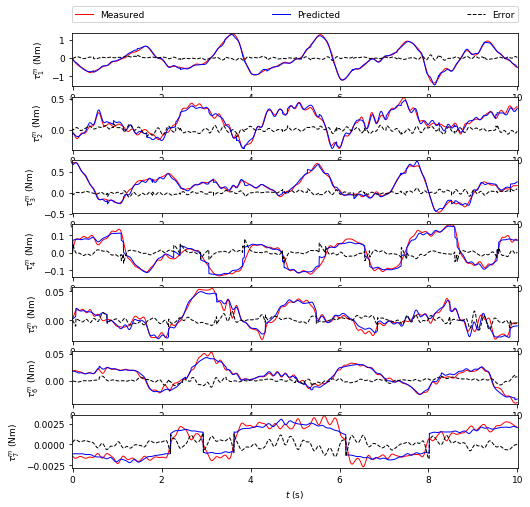

In [259]:
plot_data_num = int(1.0 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_with_cable_train[:plot_data_num, :],
                   tau_p_sdp_with_cable_train[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [ ]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

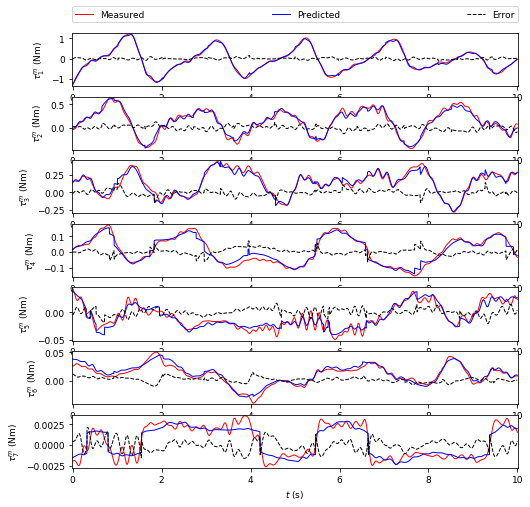

In [260]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
    
# add cable torque back
qm4_f_test = 0.6697*q_f_test[:,1] - 0.6697*q_f_test[:,2] + q_f_test[:,3]
tau_cable4_f_test = p[0]*qm4_f_test**7 + p[1]*qm4_f_test**6 + p[2]*qm4_f_test**5\
+ p[3]*qm4_f_test**4 + p[4]*qm4_f_test**3 + p[5]*qm4_f_test**2\
+ p[6]*qm4_f_test + p[7]
tau_f_with_cable_test = copy.deepcopy(tau_f_test);
tau_f_with_cable_test[:,1] = tau_f_test[:,1] + 0.6697*tau_cable4_f_test
tau_f_with_cable_test[:,2] = tau_f_test[:,2] - 0.6697*tau_cable4_f_test
tau_f_with_cable_test[:,3] = tau_f_test[:,3] + tau_cable4_f_test
tau_p_sdp_with_cable_test = copy.deepcopy(tau_p_sdp_test);
tau_p_sdp_with_cable_test[:,1] = tau_p_sdp_test[:,1] + 0.6697*tau_cable4_f_test
tau_p_sdp_with_cable_test[:,2] = tau_p_sdp_test[:,2] - 0.6697*tau_cable4_f_test
tau_p_sdp_with_cable_test[:,3] = tau_p_sdp_test[:,3] + tau_cable4_f_test

plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_with_cable_test[:plot_data_num, :],
                   tau_p_sdp_with_cable_test[:plot_data_num, :],
                   robot_def.coordinates_joint_type,
                   robot_model.coordinates)

In [261]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.0725761 , 0.15128423, 0.16236265, 0.2237137 , 0.27040664,
       0.23305066, 0.33959909])

In [262]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx    4.30008300313172   ⎤
⎢                           ⎥
⎢L1xy  -1.33446959675596e-14⎥
⎢                           ⎥
⎢L1xz  -6.12588158302775e-24⎥
⎢                           ⎥
⎢L1yy    4.30008300313176   ⎥
⎢                           ⎥
⎢L1yz  4.42652415245086e-17 ⎥
⎢                           ⎥
⎢L1zz   3.59986042757655e-7 ⎥
⎢                           ⎥
⎢l1x   -2.7414478218361e-23 ⎥
⎢                           ⎥
⎢l1y   -1.73620877454451e-17⎥
⎢                           ⎥
⎢l1z     0.619796063149997  ⎥
⎢                           ⎥
⎢ m₁     3.87518509455384   ⎥
⎢                           ⎥
⎢Fc₁    0.0432233231338211  ⎥
⎢                           ⎥
⎢Fv₁    0.0527704896732491  ⎥
⎢                           ⎥
⎢Fo₁    -0.0571610325862908 ⎥
⎢                           ⎥
⎢L2xx   0.00651440180886481 ⎥
⎢                           ⎥
⎢L2xy   0.00299315491773486 ⎥
⎢                           ⎥
⎢L2xz   0.0069946980811909  ⎥
⎢                           ⎥
⎢L2yy   0.0331184939914086  ⎥
⎢         

In [263]:
from identification import barycentric2standard_params

In [264]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [265]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx    4.20095298726845   ⎤
⎢                           ⎥
⎢I1xy  -1.33446959675596e-14⎥
⎢                           ⎥
⎢I1xz  -1.05105458657561e-23⎥
⎢                           ⎥
⎢I1yy    4.20095298726849   ⎥
⎢                           ⎥
⎢I1yz   4.1488353873951e-17 ⎥
⎢                           ⎥
⎢I1zz   3.59986042757655e-7 ⎥
⎢                           ⎥
⎢r1x   -7.07436613979785e-24⎥
⎢                           ⎥
⎢r1y   -4.48032476431787e-18⎥
⎢                           ⎥
⎢r1z     0.159939731400457  ⎥
⎢                           ⎥
⎢ m₁     3.87518509455384   ⎥
⎢                           ⎥
⎢Fc₁    0.0432233231338211  ⎥
⎢                           ⎥
⎢Fv₁    0.0527704896732491  ⎥
⎢                           ⎥
⎢Fo₁    -0.0571610325862908 ⎥
⎢                           ⎥
⎢I2xx   0.00361495282564307 ⎥
⎢                           ⎥
⎢I2xy   0.0019998444976819  ⎥
⎢                           ⎥
⎢I2xz  0.000540513724975356 ⎥
⎢                           ⎥
⎢I2yy   0.0155787987955269  ⎥
⎢         